Implementing XGBoost Regression model

Estimate and plot different error metrics (RMSE, MSE, MAE, Average Error) in a 20 runs of a XGBoost Regression model. ***Each runs has a different 20/80 test training split, and with the stratified data.***
The point is that the estimation could be done for two different set of bins and for mode with and without overfitting reduction. So, this makes possibility to check the difference in estimated errors according to different set of bins and also to have comparison between reducedoverfitting model and overfitting model.

In [ ]:
%load_ext jupyter_black

In [ ]:
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error

from utils import get_clean_dataset

In [ ]:
df = get_clean_dataset()

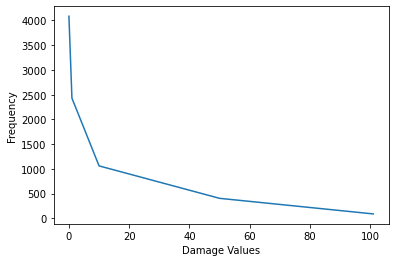

In [50]:
#The Old and New set of bins
#bins2= [0, 1, 60, 101]
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df['DAM_perc_dmg'], bins=bins2)
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:],samples_per_bin2)

In [51]:
print(samples_per_bin2)
print(binsP2)

[4086 2431 1061  405   90]
[0.00e+00 9.00e-05 1.00e+00 1.00e+01 5.00e+01 1.01e+02]


In [52]:
bin_index2=np.digitize(df['DAM_perc_dmg'], bins=binsP2)

In [53]:
y_input_strat=bin_index2

In [54]:
#the Beginning time to run the model 20 times
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-11-10 02:30:24


In [55]:
#Dropping highly correlated features which their correlation values are greater than 0.99.
features =[
    'HAZ_rainfall_Total', 
    'HAZ_rainfall_max_6h',
    'HAZ_rainfall_max_24h',
    'HAZ_v_max',
    'HAZ_v_max_3',
    'HAZ_dis_track_min',
    'GEN_landslide_per',
    'GEN_stormsurge_per',
    #'GEN_Bu_p_inSSA', 
    #'GEN_Bu_p_LS', 
    'GEN_Red_per_LSbldg',
    'GEN_Or_per_LSblg', 
    'GEN_Yel_per_LSSAb', 
    #'GEN_RED_per_SSAbldg',
    'GEN_OR_per_SSAbldg',
    'GEN_Yellow_per_LSbl',
    'TOP_mean_slope',
    'TOP_mean_elevation_m', 
    'TOP_ruggedness_stdev', 
    #'TOP_mean_ruggedness',
    #'TOP_slope_stdev', 
    'VUL_poverty_perc',
    'GEN_with_coast',
    'GEN_coast_length', 
    'VUL_Housing_Units',
    'VUL_StrongRoof_StrongWall', 
    'VUL_StrongRoof_LightWall',
    'VUL_StrongRoof_SalvageWall', 
    'VUL_LightRoof_StrongWall',
    'VUL_LightRoof_LightWall', 
    'VUL_LightRoof_SalvageWall',
    'VUL_SalvagedRoof_StrongWall',
    'VUL_SalvagedRoof_LightWall',
    'VUL_SalvagedRoof_SalvageWall', 
    'VUL_vulnerable_groups',
    'VUL_pantawid_pamilya_beneficiary']

# Split X and y from dataframe features
X = df[features]
display(X)
y = df["DAM_perc_dmg"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

train_RMSE_list=[]
test_RMSE_list=[]

train_MSE_list=[]
test_MSE_list=[]

train_MAE_list=[]
test_MAE_list=[]

train_AVE_list=[]
test_AVE_list=[]

for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled,df['DAM_perc_dmg'], stratify=y_input_strat, test_size=0.2)

    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    
    #XGBoost
    #xgb = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, gamma=1, reg_lambda=0.1, colsample_bytree=0.8)
    #xgb_model=xgb.fit(X_train, y_train)
    
     
    #XGBoost Reduced Overfitting 
    xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
                       colsample_bynode=0.8, colsample_bytree=0.8, gamma=3, eta=0.01,
                       importance_type='gain', learning_rate=0.1, max_delta_step=0,
                       max_depth=4, min_child_weight=1, missing=1, n_estimators=100, early_stopping_rounds=10,
                       n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
                       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                       silent=None, subsample=0.8, verbosity=1, eval_metric=["rmse", "logloss"]
                      )

    eval_set = [(X_test, y_test)]
    xgb_model=xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    
    
    X2 = sm.add_constant(X_train)
    est = sm.OLS(y_train, X2)
    est2 = est.fit()
    print(est2.summary())
    
    
    y_pred_train = xgb.predict(X_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    mx_train = max_error(y_train, y_pred_train)
    me_train = (y_pred_train - y_train).sum()/len(y_train)

    y_pred = xgb.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mx = max_error(y_test, y_pred)
    me = (y_pred - y_test).sum()/len(y_test)

    print('----- Test  ------')
    print(f'Mean absolute error: {mae:.2f}')
    print(f'Mean squared error: {mse:.2f}')
    print(f'Root mean squared error: {rmse:.2f}')
    print(f'Max error: {mx:.2f}')
    print(f"Average Error: {me:.2f}")

    print('---- Training -----')
    print(f'Mean absolute error: {mae_train:.2f}')
    print(f'Mean squared error: {mse_train:.2f}')
    print(f'Root mean squared error: {rmse_train:.2f}')
    print(f'Max error: {mx_train:.2f}')
    print(f"Average Error: {me_train:.2f}")
   
     
    score = xgb.score(X_train, y_train)  
    print("Training score coefficient of determination for XGboost R^2: %.3f " % (score))
    
    
    test_RMSE_list.append(rmse)
    train_RMSE_list.append(rmse_train)
    
    test_MSE_list.append(mse)
    train_MSE_list.append(mse_train)
    
    test_MAE_list.append(mae)
    train_MAE_list.append(mae_train)
    
    test_AVE_list.append(me)
    train_AVE_list.append(me_train)
    
print(test_RMSE_list)    
print(train_RMSE_list) 

print(test_MSE_list)    
print(train_MSE_list)

print(test_MAE_list)    
print(train_MAE_list)
    

,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Red_per_LSbldg,GEN_Or_per_LSblg,...,VUL_StrongRoof_LightWall,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary
0,185.828571,14.716071,7.381696,55.032241,166667.757548,2.478142,2.64,6.18,1.17,0.03,...,8.211552,0.097425,2.533055,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,46.931106
2,8.818750,0.455208,0.255319,8.728380,664.968323,288.358553,0.06,0.00,0.06,0.00,...,33.639236,0.850008,1.218595,13.645253,0.549120,0.030089,0.090266,0.112833,3.338873,25.989168
4,24.175000,2.408333,0.957639,10.945624,1311.358762,274.953818,1.52,1.28,0.02,0.00,...,22.963749,0.197179,0.667374,15.592295,0.075838,0.000000,0.015168,0.075838,2.131755,32.185651
6,14.930000,1.650000,0.586250,12.108701,1775.385328,252.828578,0.00,0.00,0.00,0.00,...,16.179723,0.279362,0.675125,7.100454,0.023280,0.011640,0.000000,0.128041,1.589369,29.612385
7,13.550000,1.054167,0.528125,10.660943,1211.676901,258.194381,5.52,0.36,0.00,0.00,...,32.522996,0.065703,0.821288,30.354796,0.000000,0.000000,0.032852,0.000000,1.387007,35.052562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25835,9.700000,0.408333,0.216146,8.136932,538.743551,277.107823,1.80,6.25,0.12,0.00,...,19.563863,0.186916,3.613707,32.492212,0.311526,0.031153,0.155763,0.031153,2.827833,31.308411
25837,17.587500,1.414583,0.386458,9.818999,946.676507,305.789817,0.00,0.00,0.00,0.00,...,13.456446,0.209059,0.383275,4.703833,0.027875,0.000000,0.034843,0.097561,1.073268,12.766551
25838,11.487500,0.614583,0.230319,15.791907,3938.254316,210.313249,0.06,0.09,0.06,0.00,...,22.347376,0.202748,0.090110,3.063753,0.022528,0.000000,0.067583,0.022528,1.140109,9.348952
25839,11.600000,1.400000,0.412766,13.867145,2666.620370,218.189328,0.00,0.00,0.00,0.00,...,29.584121,0.000000,0.094518,3.119093,0.000000,0.000000,0.000000,0.000000,2.837537,21.928166


(6458, 31) (6458,)
(1615, 31) (1615,)
                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     178.3
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        02:30:29   Log-Likelihood:                -21559.
No. Observations:                6458   AIC:                         4.318e+04
Df Residuals:                    6426   BIC:                         4.340e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     173.3
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        02:30:30   Log-Likelihood:                -21610.
No. Observations:                6458   AIC:                         4.328e+04
Df Residuals:                    6426   BIC:                         4.350e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4650      0.086     28.746      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     185.6
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        02:30:32   Log-Likelihood:                -21376.
No. Observations:                6458   AIC:                         4.282e+04
Df Residuals:                    6426   BIC:                         4.303e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4381      0.083     29.474      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     188.9
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        02:30:33   Log-Likelihood:                -21401.
No. Observations:                6458   AIC:                         4.287e+04
Df Residuals:                    6426   BIC:                         4.308e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4204      0.083     29.152      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     184.3
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        02:30:34   Log-Likelihood:                -21379.
No. Observations:                6458   AIC:                         4.282e+04
Df Residuals:                    6426   BIC:                         4.304e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4115      0.083     29.143      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     185.3
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        02:30:35   Log-Likelihood:                -21535.
No. Observations:                6458   AIC:                         4.313e+04
Df Residuals:                    6426   BIC:                         4.335e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4418      0.085     28.805      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     180.3
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        02:30:36   Log-Likelihood:                -21499.
No. Observations:                6458   AIC:                         4.306e+04
Df Residuals:                    6426   BIC:                         4.328e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4913      0.084     29.559      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     179.9
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        02:30:37   Log-Likelihood:                -21499.
No. Observations:                6458   AIC:                         4.306e+04
Df Residuals:                    6426   BIC:                         4.328e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4567      0.084     29.150      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     178.8
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        02:30:39   Log-Likelihood:                -21527.
No. Observations:                6458   AIC:                         4.312e+04
Df Residuals:                    6426   BIC:                         4.334e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4348      0.085     28.756      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     172.7
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        02:30:40   Log-Likelihood:                -21557.
No. Observations:                6458   AIC:                         4.318e+04
Df Residuals:                    6426   BIC:                         4.339e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4458      0.085     28.759      0.0

In [56]:
#the End time of running the model 20 times
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-11-10 02:30:41


stdev_AVERAGE_test: 0.17
stdev_AVERAGE_train: 0.09
mean_AVERAGE_test: -0.11
mean_AVERAGE_train: -0.11


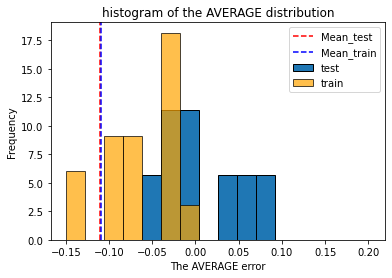

In [57]:
#Average Error

m_test_ave = statistics.mean(test_AVE_list)
plt.axvline(m_test_ave, color='red', linestyle='dashed')
plt.hist(test_AVE_list, bins=np.arange(-0.15,0.22,0.022), edgecolor='k', histtype ='bar', density=True)
sd_test_ave = statistics.stdev(test_AVE_list)

m_train_ave = statistics.mean(train_AVE_list)
plt.axvline(m_train_ave, color='b', linestyle='dashed')
plt.hist(train_AVE_list, color='orange', edgecolor='k', bins=np.arange(-0.15,0.22,0.022), histtype ='bar', density=True, alpha=0.7)
sd_train_ave = statistics.stdev(train_AVE_list)

print(f'stdev_AVERAGE_test: {sd_test_ave:.2f}')
print(f'stdev_AVERAGE_train: {sd_train_ave:.2f}')

print(f'mean_AVERAGE_test: {m_test_ave:.2f}')
print(f'mean_AVERAGE_train: {m_train_ave:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The AVERAGE error')
plt.ylabel('Frequency')
plt.title('histogram of the AVERAGE distribution')
plt.show()

stdev_MAE_test: 0.07
stdev_MAE_train: 0.08
mean_MAE_test: 1.93
mean_MAE_train: 1.64


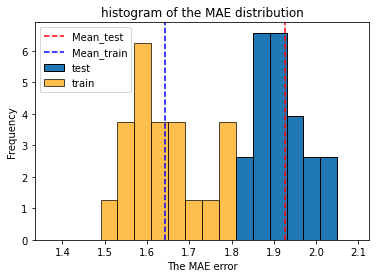

In [58]:
#MAE

m_test_mae = statistics.mean(test_MAE_list)
plt.axvline(m_test_mae, color='red', linestyle='dashed')
plt.hist(test_MAE_list, bins=np.arange(1.37,2.1,0.04), edgecolor='k', histtype ='bar', density=True)
sd_test_mae = statistics.stdev(test_MAE_list)
#plt.axvline(m+sd, color='b', linestyle='dashed')
#plt.axvline(m-sd, color='b', linestyle='dashed')


m_train_mae = statistics.mean(train_MAE_list)
plt.axvline(m_train_mae, color='b', linestyle='dashed')
plt.hist(train_MAE_list, color='orange', edgecolor='k', bins=np.arange(1.37,2.1,0.04), histtype ='bar', density=True, alpha=0.7)

sd_train_mae = statistics.stdev(train_MAE_list)
#plt.axvline(m+sd, color='y', linestyle='dashed')
#plt.axvline(m-sd, color='y', linestyle='dashed')

print(f'stdev_MAE_test: {sd_test_mae:.2f}')
print(f'stdev_MAE_train: {sd_train_mae:.2f}')

print(f'mean_MAE_test: {m_test_mae:.2f}')
print(f'mean_MAE_train: {m_train_mae:.2f}')


#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The MAE error')
plt.ylabel('Frequency')
plt.title('histogram of the MAE distribution')
plt.show()

stdev_RMSE_test: 0.37
stdev_RMSE_train: 0.35
mean_RMSE_test: 5.80
mean_RMSE_train: 4.80


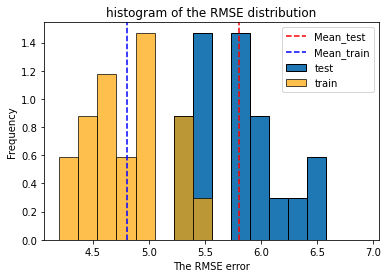

In [59]:
#RMSE

m_test_rmse = statistics.mean(test_RMSE_list)
plt.axvline(m_test_rmse, color='red', linestyle='dashed')
plt.hist(test_RMSE_list, bins=np.arange(4.2,7.0,0.17), #color='b',
         edgecolor='k', histtype ='bar', density=True, #alpha=0.5
        )
sd_test_rmse = statistics.stdev(test_RMSE_list)
#plt.axvline(m+sd, color='b', linestyle='dashed')
#plt.axvline(m-sd, color='b', linestyle='dashed')


m_train_rmse = statistics.mean(train_RMSE_list)
plt.axvline(m_train_rmse, color='b', linestyle='dashed')
plt.hist(train_RMSE_list, bins=np.arange(4.2,7.0,0.17), color='orange', edgecolor='k', histtype ='bar', density=True, alpha=0.7)

sd_train_rmse = statistics.stdev(train_RMSE_list)
#plt.axvline(m+sd, color='y', linestyle='dashed')
#plt.axvline(m-sd, color='y', linestyle='dashed')

print(f'stdev_RMSE_test: {sd_test_rmse:.2f}')
print(f'stdev_RMSE_train: {sd_train_rmse:.2f}')

print(f'mean_RMSE_test: {m_test_rmse:.2f}')
print(f'mean_RMSE_train: {m_train_rmse:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The RMSE error')
plt.ylabel('Frequency')
plt.title('histogram of the RMSE distribution')
plt.show()

stdev_MSE_test: 4.31
stdev_MSE_train: 3.36
mean_MSE_test: 33.79
mean_MSE_train: 23.20


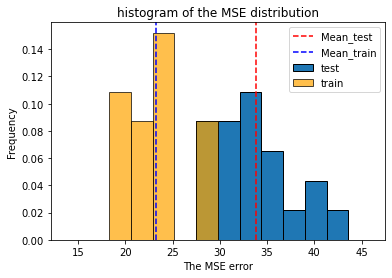

In [60]:
#MSE

m_test_mse = statistics.mean(test_MSE_list)
plt.axvline(m_test_mse, color='red', linestyle='dashed')
plt.hist(test_MSE_list, bins=np.arange(13.7,47.0,2.3), #color='b',
         edgecolor='k', histtype ='bar', density=True)

m_train_mse = statistics.mean(train_MSE_list)
plt.axvline(m_train_mse, color='b', linestyle='dashed')
plt.hist(train_MSE_list, color='orange', bins=np.arange(13.7,47.0,2.3), edgecolor='k', histtype ='bar', density=True, alpha=0.7)

sd_train_mse = statistics.stdev(train_MSE_list)
sd_test_mse = statistics.stdev(test_MSE_list)

print(f'stdev_MSE_test: {sd_test_mse:.2f}')
print(f'stdev_MSE_train: {sd_train_mse:.2f}')

print(f'mean_MSE_test: {m_test_mse:.2f}')
print(f'mean_MSE_train: {m_train_mse:.2f}')


#create legend
colors_2 = ["lime", "blue"]
labels_2= ["test","train"]
#plt.legend(labels_2)


#create legend
colors = ["tan", "red"]
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The MSE error')
plt.ylabel('Frequency')
plt.title('histogram of the MSE distribution')
plt.show()

###Codes in the following cells displays the estimated errors in a single run of Random Forest Regression Model.

In [61]:
X = df[features]
#display(X.columns)
y = df["DAM_perc_dmg"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled,df['DAM_perc_dmg'], stratify=y_input_strat, 
                                                    test_size=0.2) 


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(6458, 31) (6458,)
(1615, 31) (1615,)


In [62]:
# create an xgboost Reduced Overfitting

xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
                   colsample_bynode=0.8, colsample_bytree=0.8, gamma=3, eta=0.01,
                   importance_type='gain', learning_rate=0.1, max_delta_step=0,
                   max_depth=4, min_child_weight=1, missing=1, n_estimators=100, early_stopping_rounds=10,
                   n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
                   reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                   silent=None, subsample=0.8, verbosity=1, eval_metric=["rmse", "logloss"])

    
eval_set = [(X_test, y_test)]
xgb_model=xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

In [63]:
import statsmodels.api as sm
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     181.3
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        02:31:23   Log-Likelihood:                -21484.
No. Observations:                6458   AIC:                         4.303e+04
Df Residuals:                    6426   BIC:                         4.325e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4444      0.084     29.071      0.0

In [64]:
y_pred_train = xgb.predict(X_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mx_train = max_error(y_train, y_pred_train)
me_train = (y_pred_train - y_train).sum()/len(y_train)

y_pred = xgb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mx = max_error(y_test, y_pred)
me = (y_pred - y_test).sum()/len(y_test)

print('----- Test  ------')
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print(f'Max error: {mx:.2f}')
print(f"Average Error: {me:.2f}")

print('---- Training -----')
print(f'Mean absolute error: {mae_train:.2f}')
print(f'Mean squared error: {mse_train:.2f}')
print(f'Root mean squared error: {rmse_train:.2f}')
print(f'Max error: {mx_train:.2f}')
print(f"Average Error: {me_train:.2f}")

----- Test  ------
Mean absolute error: 1.90
Mean squared error: 35.09
Root mean squared error: 5.92
Max error: 63.09
Average Error: -0.10
---- Training -----
Mean absolute error: 1.53
Mean squared error: 18.07
Root mean squared error: 4.25
Max error: 73.16
Average Error: -0.01


In [65]:
score = xgb.score(X_train, y_train)  
print("Training score coefficient of determination for XGboost R^2: %.3f " % (score))

Training score coefficient of determination for XGboost R^2: 0.788 
